# higgsml-sklearn
Using [scikit-learn](http://scikit-learn.org/stable/) with the [Higgs Boson Machine Learning Challenge](https://higgsml.lal.in2p3.fr) dataset.

_https://github.com/adambozson/higgsml-sklearn -- Adam Bozson (RHUL), June 2016_

---

## 0. Introduction
This notebook steps through the construction, validation, and evaluation of a simple signal/background classifier for the HiggsML challenge.

It assumes some knowledge of the basics of Python 2, and the ability to use a Jupyter notebook. To get started with Jupyter, click 'Help' > 'User Interface Tour' in the toolbar at the top. There are other good resources in the 'Help' menu.

This notebook uses a number of well-known packages for data handling, mathematics, and plotting. Hopefully their use in this notebook is easy to understand. To gain a little familiarity, I recommend the [_Quickstart tutorial_](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html) for `numpy` and [_10 Minutes to pandas_](http://pandas.pydata.org/pandas-docs/stable/10min.html) for the `pandas` module.

Notebooks are great for showing plots on demand. Let's set some options...

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

Here we tell the _[matplotlib](http://matplotlib.org)_ package to use a back-end (TkAgg) compatible with Mac and Linux. The `%matplotlib inline` 'magic' command tells the notebook to show us the plots.

We will use the _[Seaborn](https://web.stanford.edu/~mwaskom/software/seaborn/)_ package later on to visualise data. Here we set some options that change the way _matplotlib_ draws plots.

In [2]:
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.set_color_codes()

As a simple 'hello world' example, plot a sin curve...

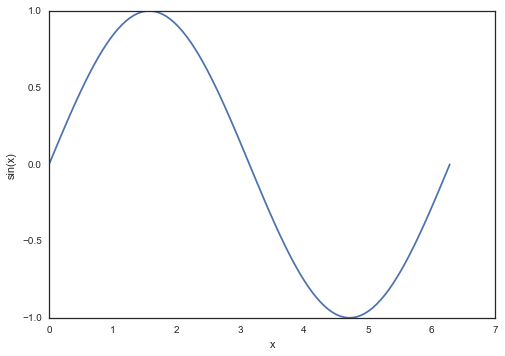

In [3]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)
plt.plot(x, y)
plt.xlabel('x'), plt.ylabel('sin(x)')
plt.show()

## 1. Load the data
We will use [pandas](http://pandas.pydata.org) to handle the data. pandas provides a wrapper around numpy arrays which allows us to view, query, and manipulate the data easily. At its core, the data are stored in numpy arrays, which scikit-learn will use as inputs.

In [4]:
import pandas as pd
df = pd.read_csv('data/atlas-higgs-challenge-2014-v2.csv')

This loads the CSV data into a _DataFrame_. View the first ten entries...

In [5]:
df[:10]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
5,100005,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,-2.412,-0.653,56.165,0.224,3.106,193.660,0.025434,b,t,0.083414
6,100006,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,0.864,1.450,56.867,0.131,-2.767,179.877,0.000814,s,t,0.002653
7,100007,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-0.715,-1.724,-999.000,-999.000,-999.000,30.638,0.005721,s,t,0.018636
8,100008,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.614803,b,t,5.296003
9,100009,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,...,-2.767,-2.514,-999.000,-999.000,-999.000,167.735,0.000461,s,t,0.001502


We can compare the numbers of signal vs. background events...

In [6]:
df['Label'].value_counts()

b    538678
s    279560
Name: Label, dtype: int64

Even better, the sum of the weights for signal and background...

In [7]:
df.groupby('Label')['Weight'].sum()

Label
b    410999.847322
s       691.988608
Name: Weight, dtype: float64

### 1.1. Extract relevant data, classes, and weights
We must separate out the classes (signal/background) and weights...

In [8]:
classes = df['Label']
weights = df['Weight']

In [9]:
classes[:5]

0    s
1    b
2    b
3    b
4    b
Name: Label, dtype: object

See that `classes` contains values 's' and 'b'. It's more useful to convert these to 1 and 0...

In [10]:
classes = (classes == 's').astype(int)
classes[:5]

0    1
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

Now for the data we need to drop the columns that could be used by the classification algorithms to cheat, leaving only the 30 physical variables...

In [11]:
data = df.drop(['EventId', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight'], axis=1)
data[:10]

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
4,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
5,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
7,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,138.178,...,-1.761,187.299,1,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638
8,105.594,50.559,100.989,4.288,-999.000,-999.000,-999.000,2.904,4.288,65.333,...,0.024,129.804,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
9,128.053,88.941,69.272,193.392,-999.000,-999.000,-999.000,1.609,28.859,255.123,...,0.845,294.741,1,167.735,-2.767,-2.514,-999.000,-999.000,-999.000,167.735


## 2. Look at the data
It's often helpful to look at the data before diving into mutivariate methods.

First, look at the correlations between the variables...

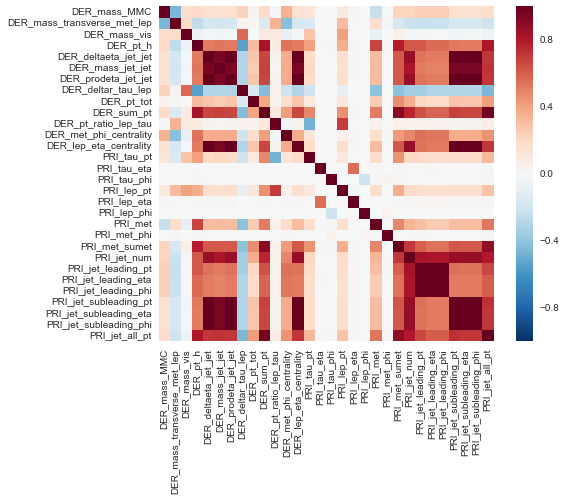

In [12]:
correlation_matrix = data.corr()
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(correlation_matrix, square=True)

What are the best variables for discriminating signal from background out of the box? Here we calculate the correlation with class for each variable and sort the results according to the absolute value...

In [13]:
correlations = []
for col in data.columns:
    vals = data[col]
    corr = np.corrcoef(vals.T, classes.T)[0,1]
    correlations.append([col, abs(corr)])
correlations = pd.DataFrame(correlations, columns=['Variable', 'Power'])
correlations.sort_values(by='Power', ascending=False)[:10]

,Variable,Power
1,DER_mass_transverse_met_lep,0.350689
11,DER_met_phi_centrality,0.271933
0,DER_mass_MMC,0.239030
13,PRI_tau_pt,0.236174
3,DER_pt_h,0.194852
10,DER_pt_ratio_lep_tau,0.193571
5,DER_mass_jet_jet,0.193064
23,PRI_jet_leading_pt,0.159574
9,DER_sum_pt,0.153840
24,PRI_jet_leading_eta,0.152520


Let's plot the 'DER_mass_transverse_met_lep' variable in a histogram to see how it discriminates...

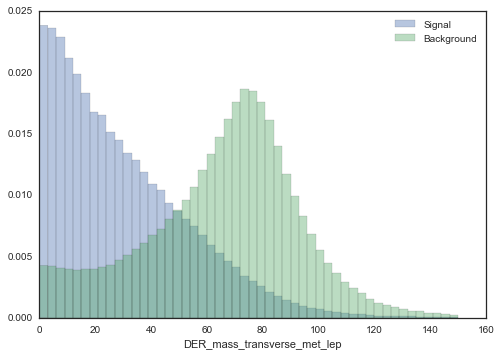

In [14]:
var = 'DER_mass_transverse_met_lep'
sel_s = (classes == 1) & (data[var] < 150)
sel_b = (classes == 0) & (data[var] < 150)
x_s = data[sel_s][var]
x_b = data[sel_b][var]
sns.distplot(x_s, kde=False, norm_hist=True, hist_kws={'weights': weights[sel_s]})
sns.distplot(x_b, kde=False, norm_hist=True, hist_kws={'weights': weights[sel_b]})
plt.legend(['Signal', 'Background'])
plt.show()

## 3. Split into training and test samples
For validation, it's important to hold back a test sample. Use scikit-learn's built-in function for randomly shuffling and splitting up the data...

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(data, classes, weights, test_size=0.5)

For training the BDT, the sum of the _training_ weights for signal and background should be equal. Renormalise the training weights for each class...

In [16]:
reweight = lambda w: w/w.sum()
w_train_normed = w_train.groupby(y_train).transform(reweight)

Let's check that worked...

In [17]:
print w_train_normed.sum()
print w_train_normed.groupby(y_train).sum()

2.0
Label
0    1.0
1    1.0
Name: Weight, dtype: float64


## 4. Create a BDT classifier

Declare an ensemble using AdaBoost, with a decision tree as the base estimator. The parameters are chosen to align with ROOT TMVA's implementation of the BDT.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Regularize based on the number of events per leaf
min_node_size = 0.05 * X_train.shape[0]

DT = DecisionTreeClassifier(splitter='random', min_samples_leaf=min_node_size)
BDT = AdaBoostClassifier(base_estimator=DT, n_estimators=200, algorithm='SAMME')

Train! Unfortunately, scikit-learn's AdaBoost (or DecisionTree) doesn't give a verbose output during training, so we have to be patient. Training takes about 4m on my 2013 MacBook Air, or 2m 30s on a state-of-the-art machine.

In [19]:
BDT = BDT.fit(X_train, y_train, sample_weight=w_train_normed.values)

## Aside: Saving/loading the classifier
If training is expensive, it is often useful to save the trained BDT object to disk so we can load it again later. This is easily achieved using _pickle_, python's native serialisation package.

In [20]:
import pickle

def save_clf(clf, path):
    with open(path, 'w') as f:
        pickle.dump(clf, f)
        
def load_clf(path):
    try:
        with open(path, 'r') as f:
            clf = pickle.load(f)
            return clf
    except IOError, EOFError:
        print 'Problem loading', path

Example use:

In [21]:
save_clf(BDT, 'BDT200.pkl')

In [22]:
BDT = load_clf('BDT200.pkl')

## 5. Validation

In order to properly compare models with different parameter values (such as the number of boosting iterations), we need a validation score. The `BDT.score` function returns the classificaion accuracy (1 - misclassification rate). The validation score must be evaluated on the independent test sample held out from the training.

In [23]:
BDT.score(X_test, y_test, sample_weight=w_test)

0.82528324929652186

To achieve the best model, this score should be minimised over the parameter space.

Comparing with the training score,

In [24]:
BDT.score(X_train, y_train, sample_weight=w_train)

0.82602892325361166

We expect the training score to be higher than the validation score, within random fluctuations. Since the difference between the training and validation scores is small, this indicates we are not in the region of overfitting.

For a more serious attempt at a classifier, we would sample the validation score over different values of the model parameters (e.g. `n_estimators`, `min_samples_leaf`, split criterion, tree depth, etc.) and try to find the global minimum. For now, we are satisfied that the classifier is not overtrained and will evaluate the model on the entire dataset.

## 6. Evaluation
How good is the trained classifier at discriminating signal and background events?

### 6.1. Split into signal and background samples
We now wish to treat the signal and background events separately, so we need to split the dataframe entries according to their labels.

This function splits every dataframe in two, depending on the class label of the event.

In [25]:
def split_sig_bkg(classes, *dataframes):
    sig = []
    bkg = []
    for df in dataframes:
        sig.append(df[classes == 1])
        bkg.append(df[classes == 0])
    return reduce(lambda a, b: a + b, zip(sig, bkg))

In [26]:
# Split the data and weights into signal/background samples
X_sig, X_bkg, w_sig, w_bkg = split_sig_bkg(classes, data, weights)

### 6.2. Get the BDT output
The BDT makes its decision based on a weighted vote from the weak learners (decision trees). The AdaBoost algorithm assigns the weight of each weak learner based on its classification accuracy, and each boosting iteration reweights the samples to give promenance to those events that are misclassified by the previous tree.

The _decision function_ is defined as 
$$\hat{y}(\vec{x}) = \sum_{k=1}^{N} \alpha_k \, f_k(\vec{x}) \, , $$
where $f_k$ is the output of the $k$th decision tree, $-1$ for a 'background' decision and $+1$ for 'signal'.

In [27]:
p_sig = BDT.decision_function(X_sig)
p_bkg = BDT.decision_function(X_bkg)

Let's plot the distributions of outputs...

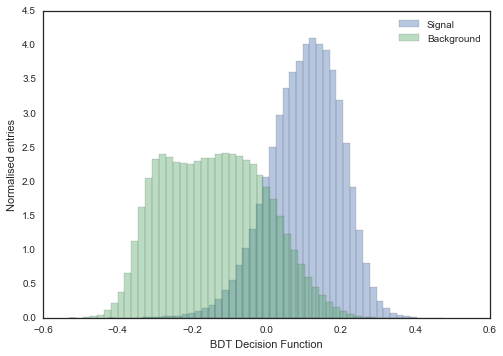

In [28]:
fig, ax = plt.subplots()
sns.distplot(p_sig, kde=False, norm_hist=True, hist_kws={'weights': w_sig})
sns.distplot(p_bkg, kde=False, norm_hist=True, hist_kws={'weights': w_bkg})
plt.xlabel('BDT Decision Function')
plt.ylabel('Normalised entries')
plt.legend(['Signal', 'Background'])
plt.show()

### 6.3. ROC AUC
The area under the [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a metric used to compare the performance of binary classifiers. An ROC AUC score of 1.0 indicates a perfect classifier, whereas a score of 0.5 indicates the classifier is no better than random guessing.

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(classes, BDT.predict(data), sample_weight=weights)

0.84192719120322435

### 6.4. Expected discovery significance
In a HEP experiment, we prefer for optimise to the expected discovery significance. Here we will calculate this metric as a function of the cut on the BDT decision function.

First, define a useful function to sum the weights of events above a certain cut value...

In [30]:
def sum_weights_above(t_cut, t, weights):
    mask = t > t_cut
    return weights[mask].sum()

Now the functions for the expected discovery significance. The median discovery significance is approximated by
$$Z_A = \sqrt{2\left((s+b) \ln(1+\frac{s}{b}) -s  \right)} \, .$$
In the large-background limit where $b \gg s$, $Z_A$ approaches $Z_0 = s/\sqrt{b}$.

In [31]:
def ZA(s, b):
    if b > 0:
        return np.sqrt(2 * ((s+b) * np.log(1 + s/b) - s))
    else:
        return np.nan
    
def Z0(s, b):
    if b > 0:
        return s / np.sqrt(b)
    else:
        return np.nan

Scan over the values for the cut (from $-0.5$ to $0.5$), calculating $s$, $b$, $Z_0$, and $Z_A$ each time. Store the results in a DataFrame...

In [32]:
cuts = np.arange(-.5, .5, .01)
rows = []
for t_cut in cuts:
    s = sum_weights_above(t_cut, p_sig, w_sig)
    b = sum_weights_above(t_cut, p_bkg, w_bkg)
    rows.append([t_cut, s, b, Z0(s, b), ZA(s, b)])
discovery_sig_df = pd.DataFrame(rows, columns=['t_cut', 's', 'b', 'Z0', 'ZA'])

Randomly sample the results to see what they look like...

In [33]:
discovery_sig_df.sample(n=10).sort_values(by='t_cut')

,t_cut,s,b,Z0,ZA
12,-0.38,691.977677,404674.326198,1.087775,1.087466
16,-0.34,691.911042,388822.155221,1.109621,1.109292
21,-0.29,691.642438,347114.562689,1.173938,1.173549
49,-0.01,607.858545,79884.330218,2.150660,2.147941
55,0.05,500.122029,37393.506122,2.586294,2.580561
64,0.14,261.679037,7542.898189,3.013005,2.995831
78,0.28,11.512956,61.736381,1.465265,1.422935
81,0.31,4.129115,10.190374,1.293486,1.218244
82,0.32,2.884551,6.129625,1.165095,1.088026
93,0.43,0.010148,0.000000,NaN,NaN


In [34]:
max_sig_idx = discovery_sig_df['ZA'].idxmax()
max_sig_data = discovery_sig_df.iloc[max_sig_idx]
max_sig = max_sig_data['ZA']
max_sig_cut = max_sig_data['t_cut']
max_sig_str = 'Max significance {:.2f} for cut value {}'.format(max_sig, max_sig_cut)
print max_sig_str

Max significance 3.00 for cut value 0.14


Plot $Z_A$ as a function of the cut value...

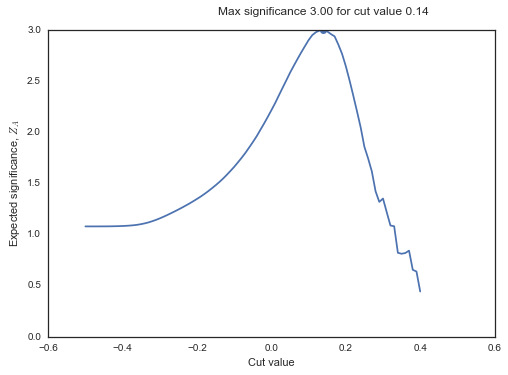

In [35]:
fig, ax = plt.subplots()
plt.plot(discovery_sig_df['t_cut'], discovery_sig_df['ZA'])
plt.xlabel('Cut value')
plt.ylabel('Expected significance, $Z_A$')
ax.plot([max_sig_cut], [max_sig], 'bo')
ax.annotate(max_sig_str,
            xy=(max_sig_cut, max_sig),
            xytext=(max_sig_cut, max_sig + .15),
            horizontalalignment='center')
# plt.savefig('significance.png') # Uncomment to save to file
plt.show()

The following function saves the dataframe to a printable text file...

In [36]:
def significance_df_to_txt(df, path):
    formatters = {'t_cut': '{:+.2f}'.format,
                  's':     '{:.3f}'.format,
                  'b':     '{:.1f}'.format,
                  'Z0':    '{:.4f}'.format,
                  'ZA':    '{:.4f}'.format
                 }
    with open(path, 'w') as f:
        f.write(df.to_string(index=False, formatters=formatters))
# Usage:
# significance_df_to_csv(discovery_sig_df, 'significance.txt')

## 7. Epilogue
Try changing the parameters in the model: the number of boosting iterations, leaf size, maximum depth, size of the test sample. These changes will have an effect on the training time as well as the validation score and discovery significance. Also try altering the discrete parameters. For example, I've found that changing the splitting algorithm from 'random' (TMVA default) to 'best' (scikit-learn default) increases the training time by about a factor of four, but results in a better classifier. Remember to optimise to validation score, not discovery significance, or you risk overfitting.